# Welter

Wednesday, June 22, 2016 (from Great Leap Brewing #12 in Beijing with Greg Herczeg)

## Clean the ASASSN data

part 1

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## ASASSN Data from Subo Dong

In [3]:
#! head ../data/photometry/LkCa4.dat

In [4]:
import pandas as pd

The header contains 3 extraneous octothorpes "###".  Read the data just to get the columns.

In [5]:
fn = '../data/photometry/LkCa4.dat'
names = pd.read_csv(fn, delim_whitespace=True, nrows=0).columns[1:]
dat = pd.read_csv(fn, delim_whitespace=True, names=names, header=0, index_col=False)

In [6]:
dat.head()

,JD,HJD,UT_date,IMAGE,FWHM,Diff,Limit,mag,mag_err,counts,counts_err,flux(mJy),flux_err
0,2.455941e+06,2.455941e+06,2012-01-14.3965239,bb001648,2.35,-1.47,16.65,12.59,0.01,23612.98,187.30,35.148,0.317
1,2.455947e+06,2.455947e+06,2012-01-20.2912569,ba003166,2.31,-1.34,16.95,12.84,0.01,21207.88,160.02,28.058,0.289
2,2.455947e+06,2.455947e+06,2012-01-20.4472960,bb001935,2.29,-1.41,16.86,12.75,0.01,21677.08,164.28,30.534,0.267
3,2.455951e+06,2.455951e+06,2012-01-24.2801167,ba003621,2.18,-1.25,16.91,12.65,0.01,27518.04,181.12,33.527,0.292
4,2.455951e+06,2.455951e+06,2012-01-24.4488822,bb002695,2.38,-1.52,16.76,12.64,0.01,21692.91,162.36,33.839,0.321


Clean the data.

In [8]:
bad_vals = dat.mag > 20.0

In [9]:
dat.drop(dat.index[bad_vals], axis=0, inplace=True)

## Convert near-contemporaneous observation "visits" into a single measurement and error

In [10]:
diff_df = pd.DataFrame({"a":dat.JD[1:].values, "b":dat.JD[0:-1].values, "c":dat.mag[1:].values})

In [11]:
diff_df['d'] = diff_df.a - diff_df.b

In [12]:
diff_df['d_min'] = diff_df.d * 24 * 60.0

Group observations by every 100 minutes chunks, or in other words observations separated by more than 100 minutes are probably separated by a few days.

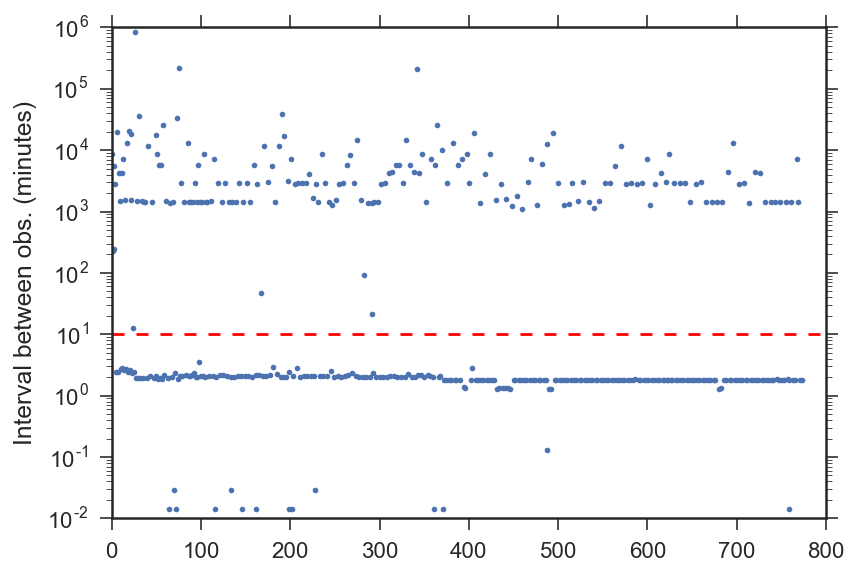

In [13]:
plt.plot(diff_df.d_min, '.')
plt.yscale('log')
plt.hlines(10, 0, 800, linestyles='dashed', colors='red')
plt.ylabel('Interval between obs. (minutes)');

In [14]:
diff_df['big_jump'] = diff_df.d_min > 10
diff_df['campaign'] = np.NAN
diff_df.campaign[diff_df.big_jump] = np.arange(diff_df.big_jump.sum())
diff_df.campaign.fillna(method='ffill', inplace=True)
diff_df.dropna(inplace=True)

(-0.5, 5.0)

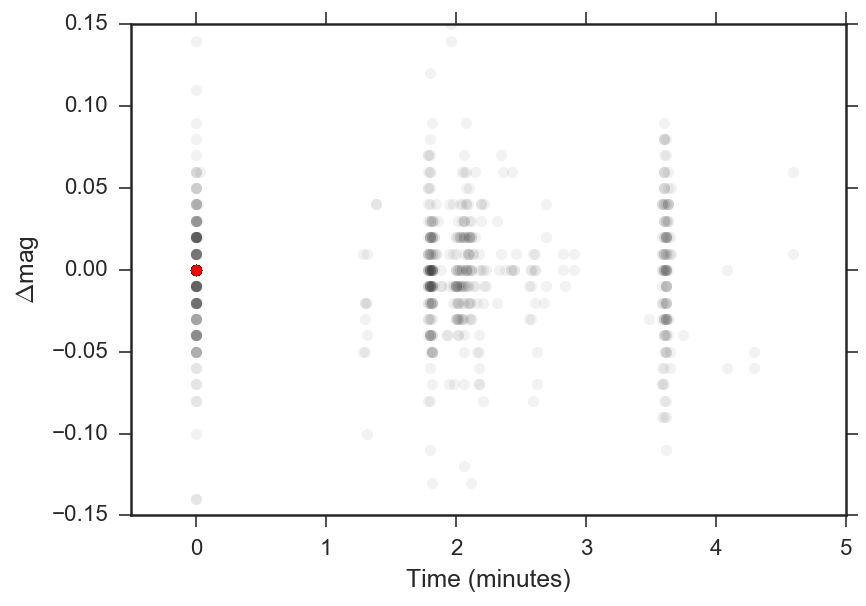

In [15]:
for name, group in diff_df.groupby('campaign'):
    plt.plot((group.a - group.a.values[0])*24.0*60, group.c-group.c.values[0], 'ko', alpha=0.05)
    #plt.plot((group.a - group.a.values[0])*24.0*60, group.c-group.c.values[0], 'r-', alpha=0.05)

plt.plot([0], [0], 'ro')
plt.xlabel('Time (minutes)')
plt.ylabel('$\Delta $mag')
plt.xlim(-0.5)

Looks like it's **just noise**.

In [21]:
grouped = diff_df.groupby('campaign')

means = grouped.aggregate({"a":np.mean, "c":np.mean})
stddevs = grouped.aggregate({"c":np.std})
n_obs = grouped.aggregate({"c":len})

aggregated_data = pd.concat([means.rename(columns={'a':'JD', 'c':'mean_mag'}), 
                             stddevs.rename(columns={'c':'stddev'}),
                             n_obs.rename(columns={'c':'n_obs'})],
                           axis=1)

aggregated_data.stddev[aggregated_data.stddev < 0.01] = 0.01
aggregated_data.stddev[aggregated_data.stddev != aggregated_data.stddev] = 0.01

Much better.  Now we just have single values for ~5 minute chunks, with error bars for spread at that observation.

In [24]:
aggregated_data.head()

,JD,mean_mag,stddev,n_obs
campaign,,,,
0.0,2.455947e+06,12.84,0.01,1.0
1.0,2.455947e+06,12.75,0.01,1.0
2.0,2.455951e+06,12.65,0.01,1.0
3.0,2.455951e+06,12.64,0.01,1.0
4.0,2.455953e+06,13.04,0.01,2.0


In [25]:
aggregated_data.tail()

,JD,mean_mag,stddev,n_obs
campaign,,,,
181.0,2.457452e+06,13.055000,0.015166,6.0
182.0,2.457453e+06,12.903333,0.015055,6.0
183.0,2.457454e+06,12.648333,0.027142,6.0
184.0,2.457459e+06,13.030000,0.028284,2.0
185.0,2.457460e+06,12.776667,0.024221,6.0


In [26]:
aggregated_data.to_csv('../data/photometry/LkCa4_ASASSN_aggregated.dat', index=False)

# The end.